<a href="https://colab.research.google.com/github/dorinhazan/Human-Activity-Recognition-Using-Smartphones/blob/main/Activity_recognition_using_smartphone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install optuna

In [5]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
from sklearn.model_selection import train_test_split


In [6]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)


In [7]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [8]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [9]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64
tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64


In [10]:
train_data['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

<Axes: xlabel='Activity'>

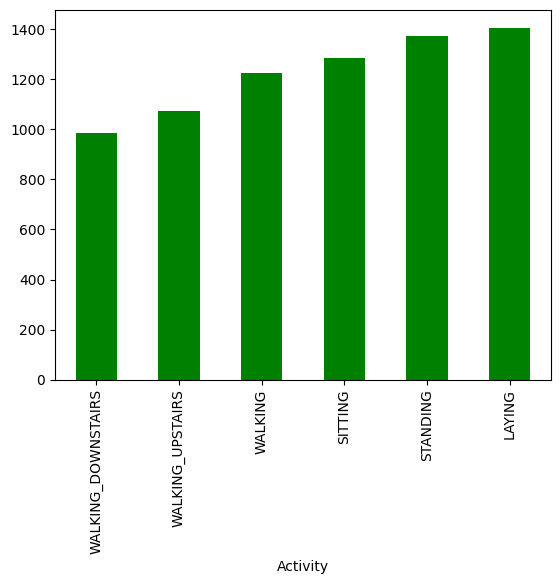

In [11]:
train_data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'green')


In [12]:
x_train, y_train = train_data.iloc[:, :-2], train_data.iloc[:, -1:]
x_train.shape, y_train.shape

((7352, 561), (7352, 1))

In [13]:
x_test, y_test = test_data.iloc[:, :-2], test_data.iloc[:, -1:]
x_test.shape, y_test.shape

((2947, 561), (2947, 1))

<ipython-input-14-4408f8ed8dd5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(data=train_data, x='Activity', palette='Set2')


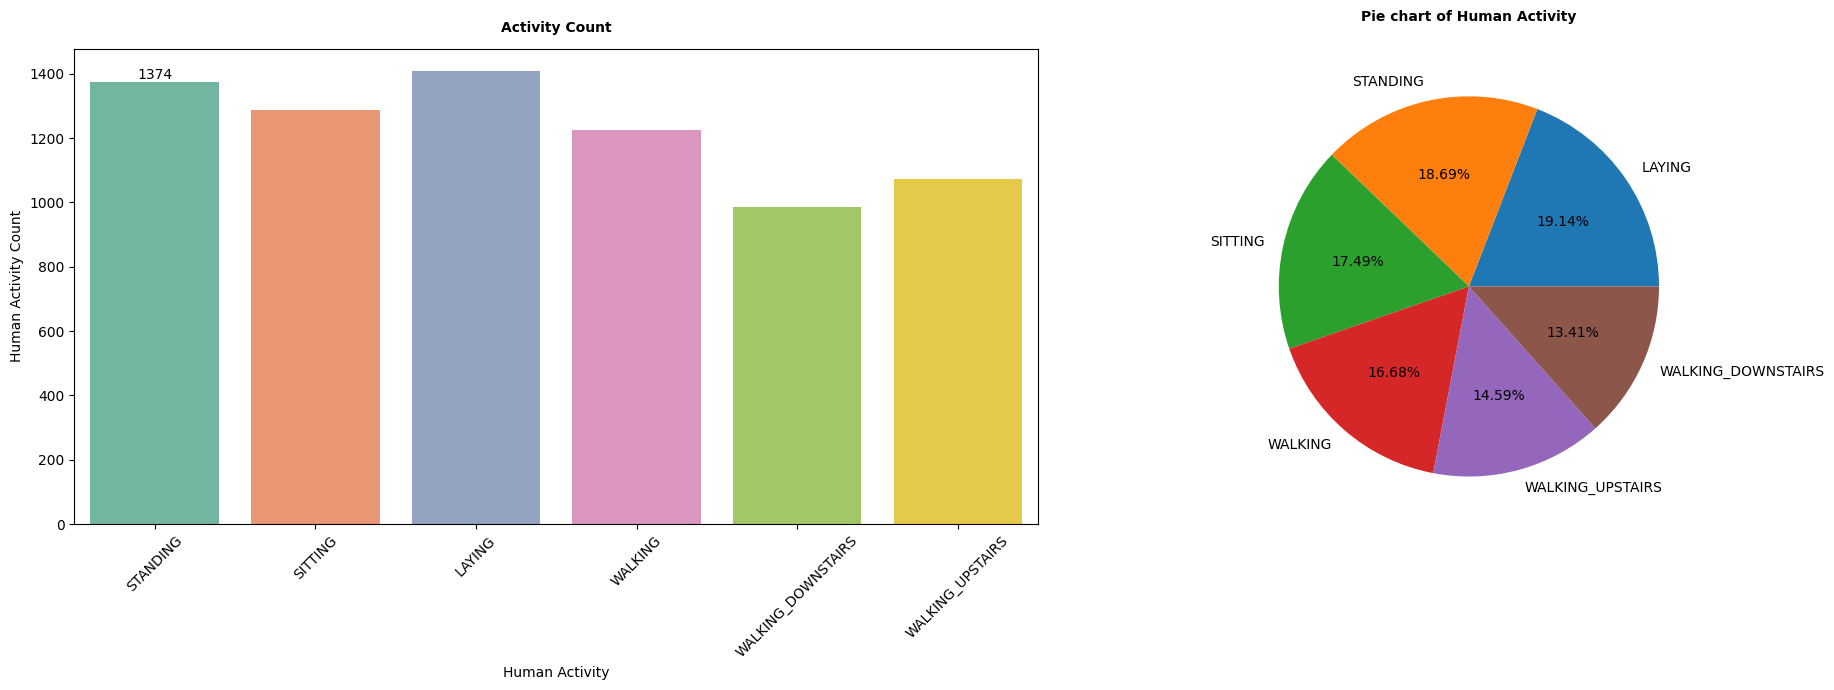

In [14]:
plt.figure(figsize=(20, 7))

# Bar Chart
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=train_data, x='Activity', palette='Set2')
plt.title("Activity Count", pad=12, fontsize=10, fontweight='bold')
plt.xlabel('Human Activity')
plt.ylabel('Human Activity Count')
plt.xticks(rotation=45)
ax1.bar_label(ax1.containers[0])

# Pie Chart
plt.subplot(1, 2, 2)
activity_count_labels = train_data['Activity'].value_counts()
plt.pie(activity_count_labels,
        autopct="%.2f%%",
        labels=activity_count_labels.index
)
plt.title("Pie chart of Human Activity", pad=20, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [16]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


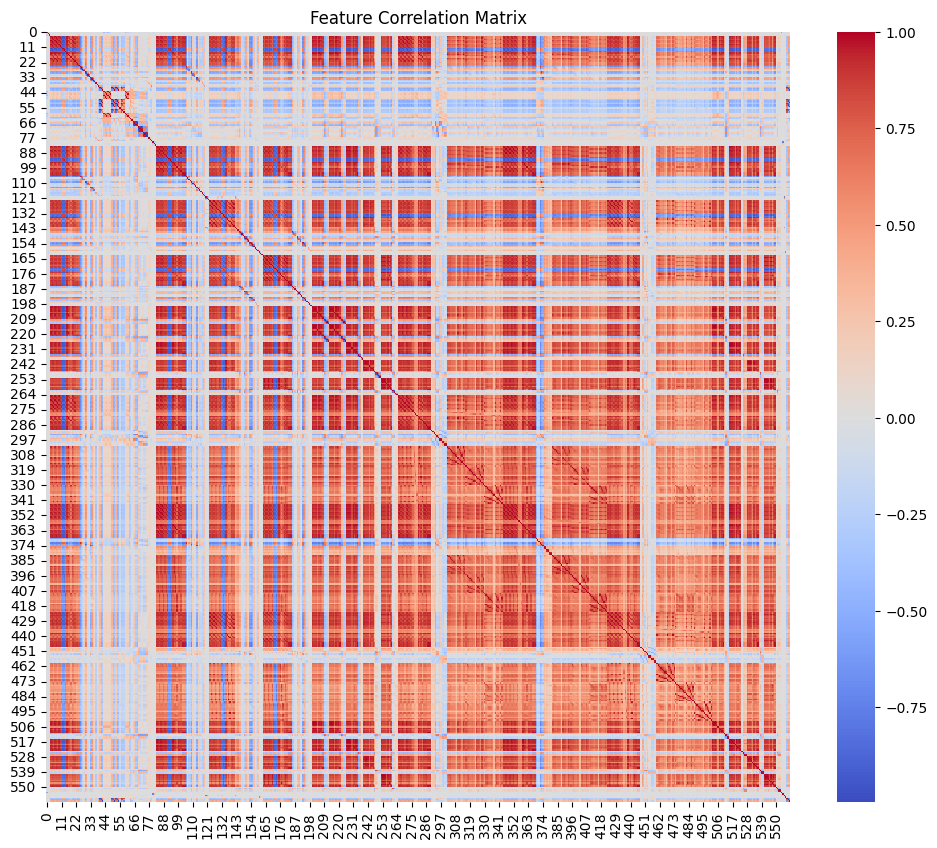

In [22]:
corr_matrix = pd.DataFrame(x_train).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [17]:
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_test = scaling_data.transform(x_test)

In [23]:
# Dimensionality Reduction via PCA
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
print('Original shape:', x_train.shape, 'PCA shape:', x_train_pca.shape)

Original shape: (7352, 561) PCA shape: (7352, 67)


Creating A Base Model With PCA

In [25]:
# Convert data to PyTorch tensors using PCA-transformed data
x_train_tensor = torch.tensor(x_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model; note the input_dim is now from x_train_pca
class ActivityClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ActivityClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 6)  # 6 output classes
        )

    def forward(self, x):
        return self.model(x)

# Update input_dim based on PCA-transformed data
input_dim = x_train_pca.shape[1]
model = ActivityClassifier(input_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/10, Loss: 0.6320
Epoch 2/10, Loss: 0.2022
Epoch 3/10, Loss: 0.1451
Epoch 4/10, Loss: 0.1162
Epoch 5/10, Loss: 0.1031
Epoch 6/10, Loss: 0.0772
Epoch 7/10, Loss: 0.0782
Epoch 8/10, Loss: 0.0680
Epoch 9/10, Loss: 0.0599
Epoch 10/10, Loss: 0.0601
Test Accuracy: 94.74%


Creating A Base Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Convert your data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class ActivityClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ActivityClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 6)  # 6 output classes
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
input_dim = x_train.shape[1]
model = ActivityClassifier(input_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10, Loss: 0.5469
Epoch 2/10, Loss: 0.1979
Epoch 3/10, Loss: 0.1391
Epoch 4/10, Loss: 0.1261
Epoch 5/10, Loss: 0.1168
Epoch 6/10, Loss: 0.0997
Epoch 7/10, Loss: 0.0949
Epoch 8/10, Loss: 0.0843
Epoch 9/10, Loss: 0.0793
Epoch 10/10, Loss: 0.0814
Test Accuracy: 94.77%
